# Mini-project: Nim

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns

from nim_env import NimEnv, OptimalPlayer

## 1. Introduction

First, we define the functions to compute the performance of an agent:

In [ ]:
def measure_performance(agent, other_epsilon):
    players = [agent, OptimalPlayer(other_epsilon)]
    N = 500
    Nwin = 0
    Nloss = 0
    env = NimEnv()
    for i in range(N):
        env.reset()
        env.current_player = i % 2

        while not env.end:
            env.step(players[env.current_player].act(env.heaps))

        if env.winner == 0:
            Nwin += 1
        else:
            Nloss += 1
    return (Nwin - Nloss) / N

def Mopt(agent):
    return measure_performance(agent, 0)
def Mrand(agent):
    return measure_performance(agent, 1)

## 2. Q-Learning

First, we have the core Q-learning logic:

In [ ]:
def get_possible_actions(heaps):
    '''
    Compute the list of allowed actions for a given state.

    Parameters
        ----------
        heaps : list of integers
                list of heap sizes.

    Returns
        -------
        actions : list of integers (heap number)
                  list of heap sizes (objects to remove)
    '''
    actions = []
    for i, heap_size in enumerate(heaps):
        for number in range(1, heap_size+1):
            actions.append((i+1, number))
    return actions

In [ ]:
class LearningAgent:
    '''
    Description:
        A class to implement an epsilon-greedy learning player in Nim.

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.
    '''
    def __init__(self, epsilon):
        self.qtable = {}
        self.epsilon = epsilon
        
        self.last_state = None
        self.last_move = None

    def get_qvalues(self, heaps):
        '''
        Get the Q-values of all the allowed actions, for a given state.

        Parameters
            ----------
            heaps : list of integers
                    list of heap sizes.
        
        Returns
            ----------
            qtable : dict of action -> Q-value
        '''
        state = tuple(heaps)
        if state not in self.qtable:
            self.qtable[state] = {action: 0 for action in get_possible_actions(state)}
        return self.qtable[state]

    def _pick_best_move(self, heaps):
        '''
        Get the move with the highest Q-value for a given state, randomly breaking ties.

        Parameters
            ----------
            heaps : list of integers
                    list of heap sizes.
    
        Returns
            ----------
            max_act : tuple
                max_act[0] is the heap to take from (starts at 1)
                max_act[1] is the number of obj to take from heap #move[0]
        '''
        # Randomly shuffle the dictionary, in order to randomly break ties.
        qvalues = list(agent.get_qvalues(heaps).items())
        random.shuffle(qvalues)
        qvalues = dict(qvalues)

        max_act = None
        for act, val in qvalues.items():
            if max_act is None or val > qvalues[max_act]:
                max_act = act
        return max_act

    def get_max_qvalue(self, heaps):
        '''
        Get the highest Q-value associated to a possible action for the given state.

        Parameters
            ----------
            heaps : list of integers
                    list of heap sizes.
    
        Returns
            ----------
            float (max Q-value)
        '''
        bestMove = self._pick_best_move(heaps)
        # If the game is already finished, return 0.
        return 0 if bestMove is None else self.get_qvalues(heaps)[bestMove]

    def act(self, heaps):
        '''
        Take an action, given the current state.

        Parameters
        ----------
        heaps : list of integers
                list of heap sizes.

        Returns
        -------
        move : list
            move[0] is the heap to take from (starts at 1)
            move[1] is the number of obj to take from heap #move[0]

        '''
        if random.random() < self.epsilon:
            # random move
            move = random.choice(list(agent.get_qvalues(heaps).keys()))
        else:
            # greedy
            move = self._pick_best_move(heaps)
        return move

In [ ]:
# Maybe we can reuse LearningAgent later for DRL? (very unlikely) Otherwise if the hole classes have to be different,
# there is no need for the QLearningAgent class, and it can be incorporated in LearningAgent
# TODO: indeed, let's incorporate them. however we can reuse run_q_learning ;)

class QLearningAgent(LearningAgent):
    def __init__(self, epsilon, alpha=0.1, gamma=0.99):
        super().__init__(epsilon)
        self.alpha = alpha
        self.gamma = gamma

    def on_step(self, state, action, reward, new_state, debug=False):
        action = tuple(action)
        old_q_value = self.get_qvalues(state)[action]
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * self.get_max_qvalue(new_state) - old_q_value)
        self.get_qvalues(state)[action] = new_q_value

        if(debug):
            print('Last state: ', state)
            print('Last action: ', action)
            print('Old qvalue: ', old_q_value, '; new qvalue: ', new_q_value, '; reward: ', reward)

In [ ]:
def call_on_step(agent, state, action, reward, next_state, debug):
    if hasattr(agent, "on_step"):
        agent.on_step(state, action, reward, next_state, debug)

def run_q_learning(env: NimEnv, agent1, agent2, debug=False, catch_invalid_moves=False):

    players = [agent1, agent2]
    if(debug):
        env.render()
    
    while not env.end:
        try:
            env.step(players[env.current_player].act(env.heaps))
        except AssertionError as err:
            if catch_invalid_moves:
                # End the game due to invalid move!
                env.end = True
                env.winner = env.current_player ^ 1
            else:
                # Otherwise make sure to propagate on invalid moves
                raise e
        if(debug):
            env.render()
        reward = int(env.end)

        if(env.num_step > 1):
            call_on_step(players[env.current_player], env.prec_state, env.prec_action, -reward, env.heaps, debug)

    # Last state rescaling (dirty solution)
    # TODO: Francesco, what does this do?
    call_on_step(players[env.current_player ^ 1], env.last_state, env.last_action, reward, env.heaps, debug)
    
    return (-1) ** env.winner

In [ ]:
# def train(agent: LearningAgent, other_agent, seed, start):
#     env = NimEnv(seed=seed)
#     env.current_player = start
#     return run_q_learning(env, agent, other_agent)

In [ ]:
# def run_q_learning_old(env: NimEnv, agent: LearningAgent, other_agent, debug=False):
#     """
#     Run one game of the q-learning algorith. The learning agent always starts. Returns the reward.
#     """
#     alpha = 0.1
#     gamma = 0.99

#     reward = -1 # if this doesn't get updated then we already lost before we even got a chance to play :(

#     while not env.end:
#         state = tuple(env.heaps)
#         # perform learning agent action
#         action = tuple(agent.act(state))
#         if debug:
#             print("state", state)
#             print("my action", action)
#         env.step(action)
#         if env.end:
#             reward = 1
#         else:
#             # if possible, perform opponent's action
#             other_action = other_agent.act(env.heaps)
#             if debug:
#                 print("other action", other_action)
#             env.step(other_action)
#             reward = -1 if env.end else 0
#         # q-learning update
#         old_q_value = agent.get_qvalues(state)[action]
#         new_q_value = old_q_value + alpha * (reward + gamma * agent.get_max_qvalue(env.heaps) - old_q_value)
#         agent.get_qvalues(state)[action] = new_q_value

#         if debug:
#             print("reward", reward)
#             print("old q value", old_q_value)
#             print("new q value", new_q_value)

#     return reward

# # remember to always pass a seed to ensure reproducible results, but make the seeds different!
# def train(agent: LearningAgent, other_agent, seed, other_starts):
#     """
#     Wrapper around `run_q_learning` that allows the other agent to start (if `other_starts` is True). Returns the reward.
#     """
#     env = NimEnv(seed=seed)
#     if other_starts:
#         env.step(other_agent.act(env.heaps))
#     return run_q_learning_old(env, agent, other_agent)

### 2.1 Learning from experts

#### Question 1

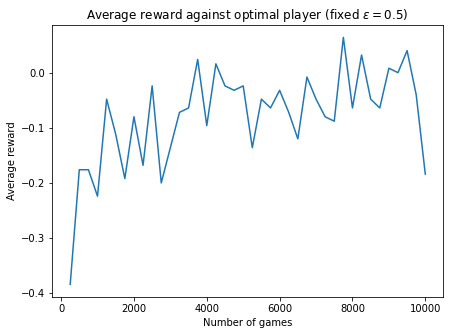

In [ ]:
# general simulation parameters
total_games = 10_000
plot_every = 250

# simulation
agent = QLearningAgent(epsilon=0.5)
expert = OptimalPlayer(epsilon=0.5)
rewards = np.zeros(total_games // plot_every)

env = NimEnv()
for game in range(total_games):
    env.reset(seed=game)
    env.current_player = game % 2
    rewards[game // plot_every] += run_q_learning(env, agent, expert, False)

plt.plot(plot_every * (1 + np.arange(total_games // plot_every)), rewards / plot_every)
plt.title(r"Average reward against optimal player (fixed $\epsilon=%s$)" % 0.5)
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.gcf().set_size_inches((7, 5))
plt.show()

We observe that our agent is indeed learning to play with a performance similar to the expert, with both having $\epsilon = 0.5$. We would expect the learning agent to beat the $\epsilon$-optimal player, but that can only happen if we reduce the $\epsilon$. We look into that in the next question.

### 2.1.1 Decreasing exploration
#### Question 2

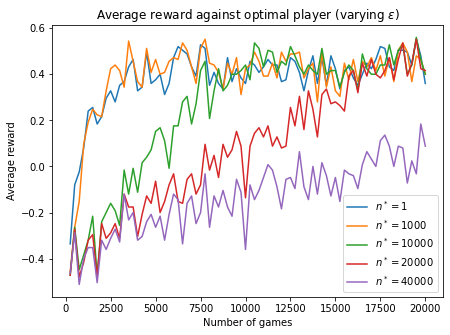

In [ ]:
total_games = 20_000
plot_every = 250

epsilon_min = 0.1
epsilon_max = 0.8

# simulation
for nstar in [1, 1_000, 10_000, 20_000, 40_000]:
    agent = QLearningAgent(epsilon_max)
    expert = OptimalPlayer(0.5)
    rewards = np.zeros(total_games // plot_every)
    env = NimEnv()

    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        agent.epsilon = max(epsilon_min, epsilon_max * (1 - (game+1) / nstar))
        rewards[game // plot_every] += run_q_learning(env, agent, expert, False)

    plt.plot(plot_every * (1 + np.arange(total_games // plot_every)), rewards / plot_every, label=r"$n^* = %d$" % nstar)
plt.title(r"Average reward against optimal player (varying $\epsilon$)")
plt.legend()
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.gcf().set_size_inches((7, 5))

plt.show()

We notice that our agent learns to play very quickly even with a low $\epsilon$. In particular,for $n^*=1$, we have $\epsilon = \epsilon_{\min} = 0.1$ for all games. However, the agent can only achieve a high reward when it is running with a low epsilon. This is particularly obvious with $n^* = 10000$ and $20000$ where we see that the average reward of the agent increases linearly as $\epsilon$ decreases.

#### Question 3

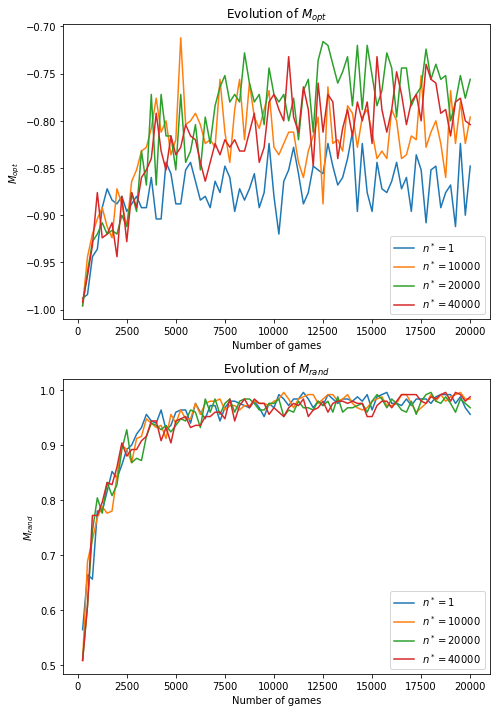

In [ ]:
total_games = 20_000
fig, axs = plt.subplots(2, 1, figsize=(7, 10))
epsilon_min = 0.1

for nstar in [1, 10_000, 20_000, 40_000]:
    agent = QLearningAgent(0)
    expert = OptimalPlayer(0.5)
    mopts = np.zeros(total_games // plot_every)
    mrands = np.zeros(total_games // plot_every)
    env = NimEnv()

    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        agent.epsilon = max(epsilon_min, epsilon_max * (1 - (game+1) / nstar))
        run_q_learning(env, agent, expert, False)

        if game % plot_every == plot_every-1:
            agent.epsilon = 0
            mopts[game // plot_every] = Mopt(agent)
            mrands[game // plot_every] = Mrand(agent)

    xs = plot_every * (1 + np.arange(total_games // plot_every))
    axs[0].plot(xs, mopts, label=r"$n^* = %d$" % nstar)
    axs[1].plot(xs, mrands, label=r"$n^* = %d$" % nstar)

axs[0].set_title("Evolution of $M_{opt}$")
axs[1].set_title("Evolution of $M_{rand}$")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Number of games")
axs[1].set_xlabel("Number of games")
axs[0].set_ylabel("$M_{opt}$")
axs[1].set_ylabel("$M_{rand}$")
fig.tight_layout()
plt.show()

(I wouldn't know how to include this in the answer because we should be talking about Opt(0.5), but it's still interesting)   
Edit: added for now in Question 8. We can eventually see later how to adjust with Q2 and Q3.

Note: For a game as Nim, if we were only playing against Opt(0) exploration is rather useless, because each move can only be good or bad, as a binary alternative, and there are no "intermediate" moves that might be good but not optimal. Also, in almost half of the situations (when the agent starts first and the nim sum is not already zero) there is always at least one good move. Therefore, the agent will never get stuck playing suboptimal moves, as it is the risk when we privilege exploitation to exploration, because eventually it will always learn which moves are good and which are bad, and afterwards which one is picked among each group makes no difference. The lower the epsilon, thus, the quicker the agent will learn to play the optimal strategy

### 2.1.2 Good experts and bad experts

#### Question 4

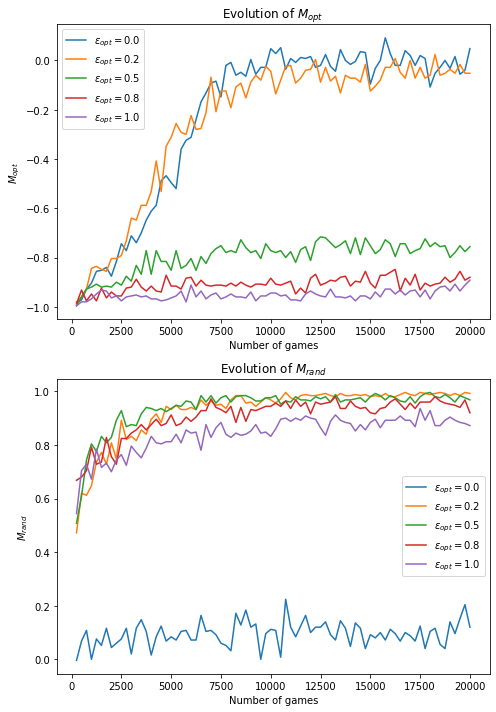

In [ ]:
nstar = 20_000
fig, axs = plt.subplots(2, 1, figsize=(7, 10))

for epsilon_opt in [0, 0.2, 0.5, 0.8, 1]:
    agent = QLearningAgent(epsilon_max)
    expert = OptimalPlayer(epsilon_opt)
    mopts = np.zeros(total_games // plot_every)
    mrands = np.zeros(total_games // plot_every)
    env = NimEnv()

    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        agent.epsilon = max(epsilon_min, epsilon_max * (1 - (game+1) / nstar))
        run_q_learning(env, agent, expert, False)

        if game % plot_every == plot_every-1:
            agent.epsilon = 0
            mopts[game // plot_every] = Mopt(agent)
            mrands[game // plot_every] = Mrand(agent)

    xs = plot_every * (1 + np.arange(total_games // plot_every))
    axs[0].plot(xs, mopts, label=r"$\epsilon_{opt} = %.1f$" % epsilon_opt)
    axs[1].plot(xs, mrands, label=r"$\epsilon_{opt} = %.1f$" % epsilon_opt)

axs[0].set_title("Evolution of $M_{opt}$")
axs[1].set_title("Evolution of $M_{rand}$")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Number of games")
axs[1].set_xlabel("Number of games")
axs[0].set_ylabel("$M_{opt}$")
axs[1].set_ylabel("$M_{rand}$")
fig.tight_layout()
plt.show()

In [ ]:
# 248 words

We observe that our agent, when trained against the best possible optimal player $Opt(0)$, learns quite quickly to play against him, equalizing the performances, but remarkably fails to outperform the naive random player $Opt(1)$.
This is an interesting effect that is due to the particular way the optimal player acts when the Nim sum is already 0 and all the moves are equally losing, taking always 1 item from the first max heap. Therefore, our agent would perfectly know the optimal move in a state such as [5, 6, 0], but would have no clue what to due if the state is [6, 5, 0]. Even, it wouldn't know anything in a state such as [7, 0, 0], because it learns to win only through [1, 0, 0]. Therefore, it cannot beat the random player, because with the latter it will get into a lot of states it has never seen before. 
On the other hand, when the agent is trained against the random player, it achieves good performances against the latter but completely fails to play against the best player. In such a situation, in fact, the agent is learning the good move in very simple positions that are one or few moves away from the end of the game, but never learns which moves are good or bad in more complex states, as it never gets punished for mistakes. For other values of $\epsilon_{opt}$, we observe instead a mix of the two mentioned situations.


#### Question 5

In general, the best possible values for the two metrics are $M_{opt} = 0$ and $M_{rand} = 1$. These can be both already obtained (on average) with $20000$ games by picking, for example, $\epsilon_{opt} = 0.2$, allowing the agent to get punished for bad moves (hence, learning good ones) and at the same time to sufficiently explore of all the winning states. 
Note that the same optimal performances of $M_{opt}$ and $M_{rand}$ could also be achieved for every value $0 < \epsilon_{opt} < 1$, but eventually with many more games.

#### Question 6

In [ ]:
# 154 words

The two agents will never learn the same Q-values, because of the different characteristics of the two players they are trained against. Even ignoring winning states which are never explored when playing against $Opt(1)$, the agent playing against $Opt(0)$ does not get punished for bad moves and will thus assign a positive reward to every complex action. Moreover, there are particular strategies that only apply to $Opt(0)$: in a losing state such as [5, 5, 0], even if in theory all moves are equally bad, the best move would be to take only 1 item from no matter which heap, because in that way the random player will have higher chances of randomly not picking the winning move in the next turn.
In conclusion, the two agents are almost playing two different games, with different strategies, states and patterns, and except for actions very close to the end the Q-values will be completely different.


### 2.2 Learning by self-practice

#### Question 7

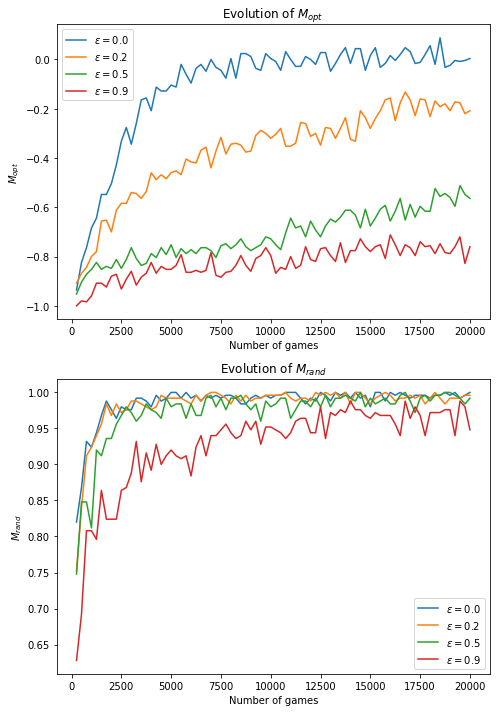

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10))
total_games = 20_000

for epsilon in [0, 0.2, 0.5, 0.9]:
    agent = QLearningAgent(epsilon)
    mopts = np.zeros(total_games // plot_every)
    mrands = np.zeros(total_games // plot_every)
    env = NimEnv()

    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        agent.epsilon = epsilon
        run_q_learning(env, agent, agent, False)

        if game % plot_every == plot_every-1:
            agent.epsilon = 0
            mopts[game // plot_every] = Mopt(agent)
            mrands[game // plot_every] = Mrand(agent)

    xs = plot_every * (1 + np.arange(total_games // plot_every))
    axs[0].plot(xs, mopts, label=r"$\epsilon = %.1f$" % epsilon)
    axs[1].plot(xs, mrands, label=r"$\epsilon = %.1f$" % epsilon)

axs[0].set_title("Evolution of $M_{opt}$")
axs[1].set_title("Evolution of $M_{rand}$")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Number of games")
axs[1].set_xlabel("Number of games")
axs[0].set_ylabel("$M_{opt}$")
axs[1].set_ylabel("$M_{rand}$")
fig.tight_layout()
plt.show()

In [ ]:
# 100 words

Our self-learning agent is learning to play Nim pretty effectively, converging to the optimal performance both against $Opt(0)$ and $Opt(1)$, the faster the smaller $\epsilon$ is. This is logical in a game such as Nim, in which each move can binarily be only good or bad and there are no  "intermediate" suboptimal moves in which an agent could get stuck because of privileging too much exploitation, assuming that it gets punished for its mistakes. Therefore, while against $Opt(0.5)$ we still needed some exploration to balance the random component, here exploration is rather useless, and lower values of $\epsilon$ converge faster.

#### Question 8

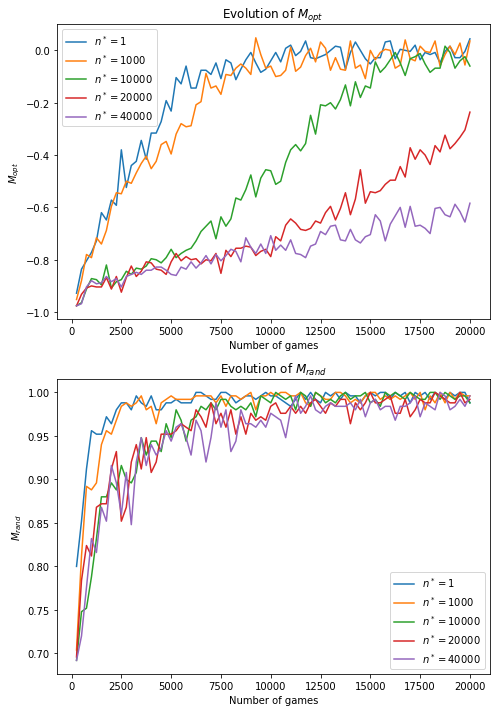

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10))
total_games = 20_000

for nstar in [1, 1000, 10_000, 20_000, 40_000]:
    agent = QLearningAgent(epsilon_max)
    mopts = np.zeros(total_games // plot_every)
    mrands = np.zeros(total_games // plot_every)
    env = NimEnv()

    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        agent.epsilon = max(epsilon_min, epsilon_max * (1 - (game+1) / nstar))
        run_q_learning(env, agent, agent, False)

        if game % plot_every == plot_every-1:
            agent.epsilon = 0
            mopts[game // plot_every] = Mopt(agent)
            mrands[game // plot_every] = Mrand(agent)

    xs = plot_every * (1 + np.arange(total_games // plot_every))
    axs[0].plot(xs, mopts, label=r"$n^* = %d$" % nstar)
    axs[1].plot(xs, mrands, label=r"$n^* = %d$" % nstar)

axs[0].set_title("Evolution of $M_{opt}$")
axs[1].set_title("Evolution of $M_{rand}$")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Number of games")
axs[1].set_xlabel("Number of games")
axs[0].set_ylabel("$M_{opt}$")
axs[1].set_ylabel("$M_{rand}$")
fig.tight_layout()
plt.show()

In [ ]:
# 49 words

Again, we see that little to no exploration is more efficient in terms of convergence, and lower values of $n^*$ are preferred. We observe, however, that decreasing $\epsilon$ over time is highly beneficial, letting the agent learn and converge faster to optimal performances even when starting with high exploration.

#### Question 9

Again, the highest values for the two metrics are $M_{opt} = 0$ and $M_{rand} = 1$, and after $20000$ games they can be achieved for example by picking $n^* = 1$ or by fixing $\epsilon = 0$. Note that, while fixing $\epsilon = 0$ is conceptually similar to training against $Opt(0)$, here the actions in a losing state are chosen not with the specific behavior of the $Opt$ player but still maximizing Q-values, and breaking ties randomly. Therefore, while in *Learning from experts* training against $Opt(0)$ led to good $M_{opt}$ but very bad $M_{rand}$, here $\epsilon = 0$ is sufficient to achieve the best possible performance.

#### Question 10

In [ ]:
agent = QLearningAgent(epsilon=0)
env = NimEnv()
for game in range(total_games):
    env.reset(seed=game)
    env.current_player = game % 2
    run_q_learning(env, agent, agent, False)

In [ ]:
def plot_heatmap(qvalues, **kwargs):
    heaps, heap_sizes = list(zip(*qvalues.keys()))
    df = pd.DataFrame({'heap': [1]*7+[2]*7+[3]*7, 'number of items': list(np.arange(7, 0, -1))*3})
    df = df.merge(pd.DataFrame({'heap': heaps, 'number of items': heap_sizes, 'qvalue': qvalues.values()}),
                  on=['heap', 'number of items'], how='outer')
    heatmap = df.pivot('heap', 'number of items', 'qvalue')
    sns.heatmap(heatmap, cmap='RdYlGn', center=0, vmin=-1, vmax=1, annot=True, **kwargs)

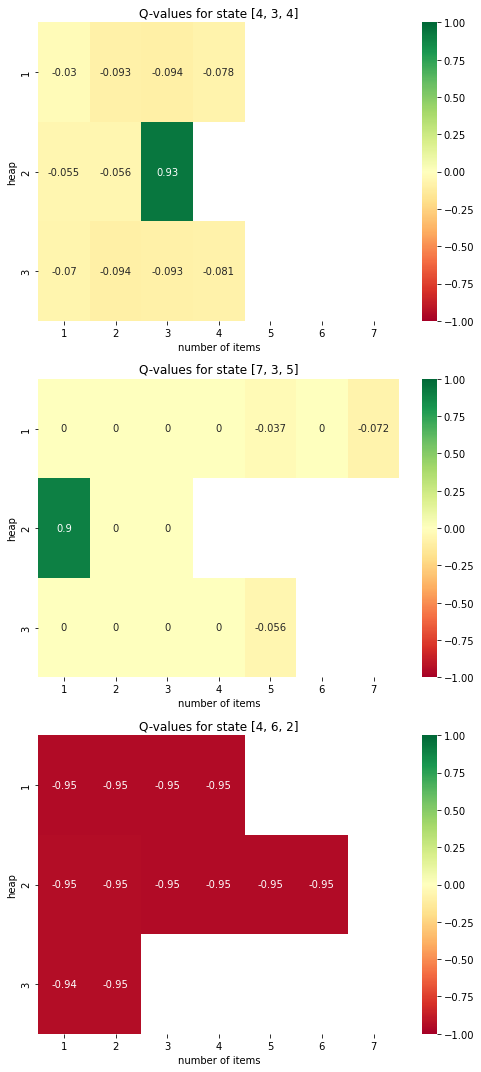

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15))

state1 = [4, 3, 4]
state2 = [7, 3, 5]
state3 = [4, 6, 2]

plot_heatmap(agent.get_qvalues(state1), ax=axs[0])
plot_heatmap(agent.get_qvalues(state2), ax=axs[1])
plot_heatmap(agent.get_qvalues(state3), ax=axs[2])

axs[0].set_title(f'Q-values for state {state1}')
axs[1].set_title(f'Q-values for state {state2}')
axs[2].set_title(f'Q-values for state {state3}')
fig.tight_layout()
plt.show()

In [ ]:
# 199 words

Q-values for the agent with $\epsilon = 0$.
We notice that in winning states, where the Nim sum is different from zero, the agent learned which move is the correct one, assigning to it a positive and high Q-value. Since the agent is playing always with the optimal policy, as soon as the good move is found once the agent sticks to it, with the result that in winning states only that move has a Q-value significantly different from 0, and there are even several actions that have never been tried and that have still a Q-value set to the initialization value 0. This is indeed the optimal behaviour, because, as already argued, once a good move is found there is no need for further exploration. On the other hand, in losing states, where the Nim sum is zero, all the actions have a negative and low Q-value. The agent, in fact, tries unsuccessfully all the possible actions to find a good one, which of course does not exist, and thus the Q-values decrease together alternating the choice of the action. This evidence shows that our agent is learning to play Nim very effectively, both in winning and losing states.

## Deep Q-Learning

Core DQN Logic:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
from line_profiler import LineProfiler

In [ ]:
# General hyperparameters
BUFFER_SIZE = 10000
BATCH_SIZE = 64
UPDATE_TARGET_EVERY = 500

In [ ]:
class DQNAgent:
    '''
    Description:
        A class to implement an epsilon-greedy learning player in Nim.

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.
    '''
    def __init__(self, epsilon, alpha=5e-4, gamma=0.99):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

        self.model = DQNAgent._create_q_model()
        self.model_target = DQNAgent._create_q_model()
        self.last_target_update = 0
        # note: deque will automatically evict the old entries once its capacity is reached
        self.replay_buffer = deque([], BUFFER_SIZE)

        # use loss and optimizer suggested in the project statement
        self.loss_function = keras.losses.Huber()
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    
        self.last_state = None
        self.last_move = None
    
    @staticmethod
    def _create_q_model():
        inputs = layers.Input(shape=(3, 3))
        # flatten since Dense expects the previous layer to have dimension 1, otherwise weird stuff happens
        layer0 = layers.Flatten(input_shape=(3, 3), name="flatten")(inputs)
        layer1 = layers.Dense(128, activation="relu", name="dense_1")(layer0)
        layer2 = layers.Dense(128, activation="relu", name="dense_2")(layer1)
        action = layers.Dense(21, activation="linear", name="output_linear")(layer2)

        return keras.Model(inputs=inputs, outputs=action)

    @staticmethod
    def _encode_heaps(heaps):
        converted = tf.convert_to_tensor([
            [(h & 4) > 0, (h & 2) > 0, (h & 1) > 0] for h in heaps
        ])
        return converted
    
    def get_qvalues(self, heaps):
        # TODO: should it be true in RL training?
        qvalues = self.model(
            tf.expand_dims(DQNAgent._encode_heaps(heaps), axis=0),
            training=False
        )
        return qvalues[0]

    def _pick_best_move(self, heaps):
        '''
        Get the move with the highest Q-value for a given state, randomly breaking ties.

        Parameters
            ----------
            heaps : list of integers
                    list of heap sizes.
    
        Returns
            ----------
            max_act : tuple
                max_act[0] is the heap to take from (starts at 1)
                max_act[1] is the number of obj to take from heap #move[0]
        '''
        # Randomly shuffle the dictionary, in order to randomly break ties.
        best_value = -1e9
        best_moves = [None]
        qvls = self.get_qvalues(heaps)
        for heap in range(3):
            for how_much in range(7):
                q_value = qvls[heap * 7 + how_much]
                if q_value >= best_value:
                    if q_value > best_value:
                        best_moves.clear()
                        best_value = q_value
                    best_moves.append((heap+1, how_much+1))
        return best_value, random.choice(best_moves)

    def get_max_qvalue(self, heaps):
        '''
        Get the highest Q-value associated to a possible action for the given state.

        Parameters
            ----------
            heaps : list of integers
                    list of heap sizes.
    
        Returns
            ----------
            float (max Q-value)
        '''
        best_value, best_move = self._pick_best_move(heaps)
        # If the game is already finished, return 0.
        return 0 if best_move is None else best_value

    def act(self, heaps):
        '''
        Take an action, given the current state.

        Parameters
        ----------
        heaps : list of integers
                list of heap sizes.

        Returns
        -------
        move : list
            move[0] is the heap to take from (starts at 1)
            move[1] is the number of obj to take from heap #move[0]

        '''
        if random.random() < self.epsilon:
            # random move
            move = random.choice(get_possible_actions(heaps))
        else:
            # greedy
            move = self._pick_best_move(heaps)[1]
        return move
    
    def on_step(self, state, action, reward, next_state, debug):
        # Convert the action from env format (1-3, 1-7) to internal format 0-20
        internal_action = (action[0]-1) * 7 + (action[1]-1)
        # Update replay buffer
        self.replay_buffer.append((
            DQNAgent._encode_heaps(state),
            internal_action,
            reward,
            DQNAgent._encode_heaps(next_state)
        ))
        
        # Sample minibatch
        minibatch_indices = np.random.choice(len(self.replay_buffer), size=BATCH_SIZE)
        minibatch = [self.replay_buffer[i] for i in minibatch_indices]
        minibatch_states = np.array([prev[0] for prev in minibatch])
        minibatch_actions = [prev[1] for prev in minibatch]
        minibatch_rewards = [prev[2] for prev in minibatch]
        minibatch_next_states = np.array([prev[3] for prev in minibatch])

        # Compute gradient
        # Q^(s_j+1)
        target_q_values = self.model_target(minibatch_next_states).numpy()
        # max_a' Q^(s_j+1)_a'
        target_term = minibatch_rewards + self.gamma * tf.reduce_max(
            target_q_values,
            axis=1
        )
        mask = tf.one_hot(minibatch_actions, 21)
        with tf.GradientTape() as tape:
            q_values = self.model(minibatch_states)
            # TODO: not sure what exactly these two lines do?
            q_action = tf.reduce_sum(tf.multiply(q_values, mask), axis=1)
            loss = self.loss_function(target_term, q_action)

        # Backprop
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Update target model
        self.last_target_update += 1
        if self.last_target_update >= UPDATE_TARGET_EVERY:
            self.model_target.set_weights(self.model.get_weights())
            self.last_target_update = 0

#### Question 13

Finished running game 0
Finished running game 100
Finished running game 200


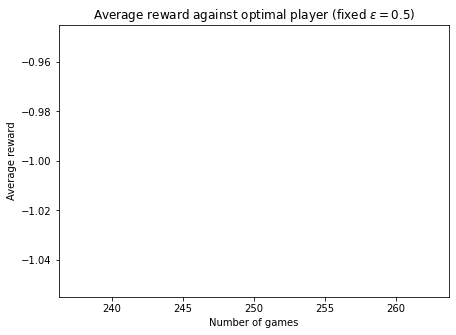

Timer unit: 1e-06 s

Total time: 70.1458 s
File: <ipython-input-39-66d54570804e>
Function: do_training at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def do_training():
    11         5        632.0    126.4      0.0      env = NimEnv()
    12      1006       5030.0      5.0      0.0      for game in range(total_games):
    13      1002     124958.0    124.7      0.2          env.reset(seed=game)
    14      1002       6058.0      6.0      0.0          env.current_player = game % 2
    15      1002   69996293.0  69856.6     99.8          rewards[game // plot_every] += run_q_learning(env, agent, expert, False, catch_invalid_moves=True)
    16      1001       7454.0      7.4      0.0          if game % 100 == 0:
    17        12       5412.0    451.0      0.0              print("Finished running game %d" % game)



In [ ]:
# general simulation parameters
total_games = 250
plot_every = 250

# simulation
agent = DQNAgent(epsilon=0.1)
expert = OptimalPlayer(epsilon=0.5)
rewards = np.zeros(total_games // plot_every)

def do_training():
    env = NimEnv()
    for game in range(total_games):
        env.reset(seed=game)
        env.current_player = game % 2
        rewards[game // plot_every] += run_q_learning(env, agent, expert, False, catch_invalid_moves=True)
        if game % 100 == 0:
            print("Finished running game %d" % game)

# We do a little profiling
profiler = LineProfiler()
profiler.add_function(run_q_learning)
profiling_wrapper = lprofiler(do_training)
profiling_wrapper()

plt.plot(plot_every * (1 + np.arange(total_games // plot_every)), rewards / plot_every)
plt.title(r"Average reward against optimal player (fixed $\epsilon=%s$)" % 0.5)
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.gcf().set_size_inches((7, 5))
plt.show()

lprofiler.print_stats()

In [ ]:
lprofiler.print_stats()
lprofiler

Timer unit: 1e-06 s

Total time: 54.8345 s
File: <ipython-input-39-66d54570804e>
Function: do_training at line 10

Line #      Hits         Time  Per Hit   % Time  Line Contents
    10                                           def do_training():
    11         4        500.0    125.0      0.0      env = NimEnv()
    12       755       3804.0      5.0      0.0      for game in range(total_games):
    13       752      92715.0    123.3      0.2          env.reset(seed=game)
    14       752       4686.0      6.2      0.0          env.current_player = game % 2
    15       752   54722983.0  72769.9     99.8          rewards[game // plot_every] += run_q_learning(env, agent, expert, False, catch_invalid_moves=True)
    16       751       5590.0      7.4      0.0          if game % 100 == 0:
    17         9       4180.0    464.4      0.0              print("Finished running game %d" % game)



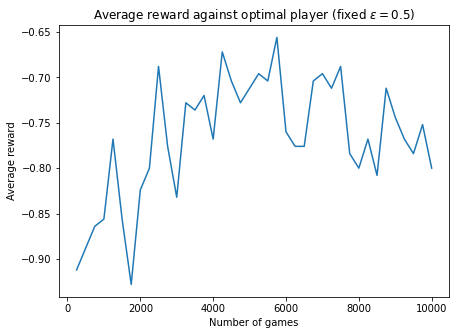

In [ ]:
plt.plot(plot_every * (1 + np.arange(total_games // plot_every)), rewards / plot_every)
plt.title(r"Average reward against optimal player (fixed $\epsilon=%s$)" % 0.5)
plt.xlabel("Number of games")
plt.ylabel("Average reward")
plt.gcf().set_size_inches((7, 5))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=463655a7-0f20-421f-83f3-cd2894d6a4d8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>